**Data sources**
- Violencia intrafamiliar: Domestic violence dataset by state (dataset): https://www.datos.gov.co/Justicia-y-Derecho/Violencia-intrafamiliar-Colombia-a-os-2016-a-2019/ers2-kerr/data : **It is very old, we need to find more recent data**
- Violencia intrafamilar de la dijin: https://www.datos.gov.co/Seguridad-y-Defensa/Reporte-Delito-Violencia-Intrafamiliar-Polic-a-Nac/vuyt-mqpw
- Suicide World trends: https://ourworldindata.org/grapher/suicide-death-rates-by-sex?time=1990..latest , https://ourworldindata.org/search?q=suicide
- Mapa de Colombia por municipios: https://www.kaggle.com/datasets/alfredomaussa/mapa-de-colombia-con-municipios?resource=download
- https://github.com/finiterank/mapa-colombia-js/blob/master/colombia-municipios.json
- https://www.datos.gov.co/Justicia-y-Derecho/Suicidios-Colombia-a-os-2016-a-2019/f75u-mirk



In [ ]:
# PRE REQS
!pip install pandas
!pip install folium

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


# RUN ME FIRST

In [ ]:
# RUN ME FIRST
#import re
import pandas as pd
import numpy as np
import folium
import seaborn as sns
import matplotlib.pyplot as plt
from folium import plugins
from folium.plugins import HeatMap

# Functions
def read_clean_violenciaintra():
    """
    Reads and clean data
    Columns at the end ['DPTO', 'MUNICIPIO', 'CODE_MUNICIPIO', 'ARMAS MEDIOS', 'DATE', 'GENDER',
                        'GRUPO ETARIO', 'CANTIDAD', 'YEAR', 'CODE_DPTO']
    """
    print("Reading and cleaning violence data ...")
    fname = "INPUTDATA/CSV/WO-Reporte_Delito_Violencia_Intrafamiliar_Polic_a_Nacional-2010-2022.csv"
    df = pd.read_csv(fname, sep=";", parse_dates=["FECHA HECHO"])
    colnames = {"DEPARTAMENTO":"DPTO", "FECHA HECHO":"DATE", "CODIGO DANE":"CODE_MUNICIPIO", "GENERO":"GENDER"}
    df.rename(columns=colnames, inplace=True)
    df["DPTO"] = df["DPTO"].str.normalize("NFKD").str.encode('ascii', errors='ignore').str.decode('utf-8').str.strip()
    df["MUNICIPIO"] = df["MUNICIPIO"].str.normalize("NFKD").str.encode('ascii', errors='ignore').str.decode('utf-8').str.strip()
    df["MUNICIPIO"] = df["MUNICIPIO"].str.replace(" D.C.", "")
    df["MUNICIPIO"] = df["MUNICIPIO"].str.replace(r" \(CT\)", "")
    df['YEAR'] = pd.to_datetime(df['DATE'], format="%Y").dt.to_period('Y')
    # Fix missing data
    mask_dpto_code= (df["DPTO"]!="NO REPORTA") & (df["CODE_MUNICIPIO"]!="NO REPORTA")
    df = df[mask_dpto_code]
    # fix dane code
    df["CODE_MUNICIPIO"] = (df["CODE_MUNICIPIO"].astype(int)/1000)
    df = df.astype({"CODE_MUNICIPIO":int}, errors='raise')
    df["CODE_DPTO"] = (df["CODE_MUNICIPIO"].astype(int)/1000)
    df = df.astype({"CODE_DPTO":int}, errors='raise')
    # fix deparment for BOGOTA: remove it from Cundinamarca
    mask = df["MUNICIPIO"] == "BOGOTA"
    df.loc[mask, "DPTO"] = "BOGOTA"
    return df

def read_clean_suicide():
    """
    Columns at the end: ['YEAR', 'GENDER, 'AGE GROUP', 'MONTH', 'WEEKDAY', 'DPTO', 'MUNICIPIO']
    """
    print("Reading and cleaning suicide data ...")
    fname = "INPUTDATA/CSV/Suicidios_2016_a_2019.csv"
    df = pd.read_csv(fname)
    # Rename columns
    colnames = {"Año del hecho": "YEAR", "Sexo de la victima":"GENDER", 
                "Grupo de edad de la victima":"AGE GROUP", "Mes del hecho":"MONTH", "Dia del hecho":"WEEKDAY",
                "Departamento del hecho DANE":"DPTO", "Municipio del hecho DANE":"MUNICIPIO"}
    df.rename(columns=colnames, inplace=True)
    # Drop non needed columns
    df.drop(columns=["Lesion fatal de causa externa", "Estado", "ID"], inplace=True)
    # Normalize names
    df["DPTO"] = df["DPTO"].str.upper().str.normalize("NFKD").str.encode('ascii', errors='ignore').str.decode('utf-8').str.strip()
    df["MUNICIPIO"] = df["MUNICIPIO"].str.upper().str.normalize("NFKD").str.encode('ascii', errors='ignore').str.decode('utf-8').str.strip()
    # Fix San Andres and Valle del Cauca name
    df["DPTO"].replace({"VALLE DEL CAUCA":"VALLE", 
                        "ARCHIPIELAGO DE SAN ANDRES, PROVIDENCIA Y SANTA CATALINA":"SAN ANDRES",
                        "BOGOTA, D.C.":"BOGOTA"}, 
                        inplace=True)
    df["MUNICIPIO"].replace({"BOGOTA, D.C.":"BOGOTA"}, inplace=True)
    df['YEAR'] = pd.to_datetime(df['YEAR'], format="%Y").dt.to_period('Y')
    df.loc[df["MUNICIPIO"].str.contains("BOGOTA"), ["DPTO", "MUNICIPIO"]] = "BOGOTA"
    df.loc[df["DPTO"].str.contains("BOGOTA"), ["DPTO", "MUNICIPIO"]] = "BOGOTA"
    return df

def read_clean_geocodes():
    """
    Columns at the end: [CODE_DPTO, CODE_MUNICIPIO, DPTO, MUNICIPIO, LONGITUD, LATITUD]
    """
    print("Reading and cleaning geo data ...")
    df = pd.read_csv("INPUTDATA/CSV/WO-CodigosDivisionPolitica.csv")
    # keep only data per municipio (NOT NEIGHBORHOODS)
    mask = df["Nombre Municipio"] == df["Nombre Centro Poblado"]
    df = df[mask]
    # Drop some uneeded columns
    df.drop(columns=["Código Centro Poblado", "Nombre Centro Poblado", "Tipo Centro Poblado",
                    "Ubicación", "Distrito", "Tipo de Municipio", "Area Metropolitana"], inplace=True)
    # Rename columns
    colnames = {"Nombre Departamento":"DPTO", "Nombre Municipio":"MUNICIPIO", 
                "Código Municipio":"CODE_MUNICIPIO", "Código Departamento":"CODE_DPTO"}
    df.rename(columns=colnames, inplace=True)
    df.rename(columns=str.upper, inplace=True)
    # Normalize names to remove accents
    df["DPTO"] = df["DPTO"].str.normalize("NFKD").str.encode('ascii', errors='ignore').str.decode('utf-8').str.strip()
    df["MUNICIPIO"] = df["MUNICIPIO"].str.normalize("NFKD").str.encode('ascii', errors='ignore').str.decode('utf-8').str.strip()
    df.loc[df["MUNICIPIO"].str.contains("BOGOTA"), ["DPTO", "MUNICIPIO"]] = "BOGOTA"
    df.loc[df["DPTO"].str.contains("BOGOTA"), ["DPTO", "MUNICIPIO"]] = "BOGOTA"
    return df

def read_clean_population_data():
    """
    Columns at the end: [CODE_DPTO, DPTO, CODE_MUNICIPIO, MUNICIPIO, YEAR, POPULATION]
    """
    print("Reading and cleaning population data ...")
    df = pd.read_csv("INPUTDATA/CSV/TOTAL POBLACION POR MUNICIPIO 2016-2022.csv", sep=";")
    df.rename(columns={"DP":"CODE_DPTO", "DPNOM":"DPTO", "COD_MUNICIPIO":"CODE_MUNICIPIO", 
                       "MPNOM":"MUNICIPIO", "AÑO":"YEAR", "Total":"POPULATION", }, inplace=True)
    df.drop(columns=['ÁREA GEOGRÁFICA'], inplace=True)
    df['YEAR'] = pd.to_datetime(df['YEAR'], format="%Y").dt.to_period('Y')
    df['POPULATION'] = df['POPULATION'].apply(lambda x: int(x.replace(".", "")))
    df['MUNICIPIO'] = df['MUNICIPIO'].apply(lambda x: x.replace(" (CD)", ""))
    df["DPTO"] = df["DPTO"].str.normalize("NFKD").str.encode('ascii', errors='ignore').str.decode('utf-8').str.strip().str.upper()
    df["MUNICIPIO"] = df["MUNICIPIO"].str.normalize("NFKD").str.encode('ascii', errors='ignore').str.decode('utf-8').str.strip().str.upper()
    df.loc[df["MUNICIPIO"].str.contains("BOGOTA"), ["DPTO", "MUNICIPIO"]] = "BOGOTA"
    df.loc[df["DPTO"].str.contains("BOGOTA"), ["DPTO", "MUNICIPIO"]] = "BOGOTA"
    return df

def merge_on_common(df1, df2, verbose=False):
    columns1 = set(list(df1.columns))
    columns2 = set(list(df2.columns))
    common_columns = columns1.intersection(columns2)
    if verbose:
        print(f"common_columns for merging: {common_columns}")
    return pd.merge(df1, df2, how="inner", on=list(common_columns))

def merge_violencia_population_geo():
    print("Merging violencia, population and geo ...")
    dfviolencia = pd.read_csv("INPUTDATA/NEWCSV/ViolenciaIntrafamiliar-2010-2022.csv")
    dfpopulation = pd.read_csv("INPUTDATA/NEWCSV/Population-2016-2022.csv")
    dfgeo = pd.read_csv("INPUTDATA/NEWCSV/CodigosDivisionPolitica.csv")
    # Group violencia per year since population is per year   
    dfviolencia = dfviolencia.groupby(["YEAR", "MUNICIPIO", "DPTO", "CODE_DPTO", "CODE_MUNICIPIO"]).sum().\
                                        sort_values("CANTIDAD", ascending=False).reset_index()
    dffull = merge_on_common(dfviolencia, dfpopulation)
    dffull = merge_on_common(dffull, dfgeo)
    return dffull

def merge_suicides_population_geo():
    print("Merging suicides, population and geo ...")
    dfsuicides = pd.read_csv("INPUTDATA/NEWCSV/Suicidios-2016-2019.csv")
    dfsuicides["SUI_COUNTER"] = 1
    # Group by year to be able to merge with yearly population
    dfsuicides = dfsuicides[["YEAR", "MUNICIPIO", "DPTO", "SUI_COUNTER"]].groupby(["YEAR", "MUNICIPIO", "DPTO"]).sum().sort_values("SUI_COUNTER", ascending=False).reset_index()
    # read other data
    dfpopulation = pd.read_csv("INPUTDATA/NEWCSV/Population-2016-2022.csv")
    dfgeo = pd.read_csv("INPUTDATA/NEWCSV/CodigosDivisionPolitica.csv")
    dffull = merge_on_common(dfsuicides, dfpopulation, verbose=True)
    dffull = merge_on_common(dffull, dfgeo, verbose=True)
    return dffull


def read_clean_suicide_2016_2022():
    # 2020 using consolidado causa
    df = pd.read_csv("INPUTDATA/CONSOLIDADO RAZON DEL SUICIDIO.csv", sep=";")
    # extract dpto and municipio
    df["DPTO"] = df["Municipio"].apply(lambda x: x.split()[0])
    df["MUNICIPIO"] = df["Municipio"].apply(lambda x: x.split('/')[-1])
    df.drop(columns="Municipio", inplace=True)
    # rename columns
    df.rename(columns={"Año":"YEAR", "Subcategoria":"CAUSE", "Sexo":"GENDER", "Valor":"SUI_COUNTER"}, inplace=True)
    # Normalize names
    df["DPTO"] = df["DPTO"].str.upper().str.normalize("NFKD").str.encode('ascii', errors='ignore').str.decode('utf-8').str.strip()
    df["MUNICIPIO"] = df["MUNICIPIO"].str.upper().str.normalize("NFKD").str.encode('ascii', errors='ignore').str.decode('utf-8').str.strip()
    df["GENDER"] = df["GENDER"].str.replace('Hombre', 'MASCULINO') 
    df["GENDER"] = df["GENDER"].str.replace('Mujer', 'FEMENINO') 
    # Fix San Andres and Valle del Cauca and Bogota name
    df["DPTO"].replace({"VALLE DEL CAUCA":"VALLE", 
                        "ARCHIPIELAGO DE SAN ANDRES, PROVIDENCIA Y SANTA CATALINA":"SAN ANDRES",
                        "BOGOTA, D.C.":"BOGOTA"}, 
                        inplace=True)
    df["MUNICIPIO"].replace({"BOGOTA, D.C.":"BOGOTA"}, inplace=True)
    df.loc[df["MUNICIPIO"].str.contains("BOGOTA"), ["DPTO", "MUNICIPIO"]] = "BOGOTA"
    df.loc[df["DPTO"].str.contains("BOGOTA"), ["DPTO", "MUNICIPIO"]] = "BOGOTA"
    #print(df[df["MUNICIPIO"].str.contains("BOG")])
    # Change year format to datetime
    df['YEAR'] = pd.to_datetime(df['YEAR'], format="%Y").dt.to_period('Y')

    # Remove data with no data points
    df = df.drop(df[(df["GENDER"] == "Indeterminado") & (df["SUI_COUNTER"] == 0)].index)

    # Load geo data
    dfgeo = pd.read_csv("INPUTDATA/NEWCSV/CodigosDivisionPolitica.csv")
    dfgeo.head()

    # merge with geo data
    df = df.merge(dfgeo, how="inner", on=["DPTO", "MUNICIPIO"], indicator=False)
    df.tail(10)

    df.to_csv("INPUTDATA/NEWCSV/MERGED-2016-2022-Suicidios-Geo-Cause.csv", index=False)
    df.head()

    df = df.groupby(by=["YEAR", "DPTO", "CODE_DPTO", "MUNICIPIO", "CODE_MUNICIPIO",  "LONGITUD", "LATITUD"]).sum().reset_index()
    # Load and merge with geodata
    dfpop = pd.read_csv("data/Population-2016-2022.csv")
    dfpop['YEAR'] = pd.to_datetime(dfpop['YEAR'], format="%Y").dt.to_period('Y')
    df = df.merge(dfpop, how="inner", on=["DPTO", "MUNICIPIO", "CODE_DPTO", "CODE_MUNICIPIO", "YEAR"], indicator=False)
    df.to_csv("INPUTDATA/NEWCSV/MERGED-2016-2022-Suicidios-Geo-Pop.csv", index=False)



def read_clean_writenewdata():
    read_clean_violenciaintra().to_csv("INPUTDATA/NEWCSV/ViolenciaIntrafamiliar-2010-2022.csv", index=False)
    read_clean_suicide().to_csv("INPUTDATA/NEWCSV/Suicidios-2016-2019.csv", index=False)
    read_clean_geocodes().to_csv("INPUTDATA/NEWCSV/CodigosDivisionPolitica.csv", index=False)
    read_clean_population_data().to_csv("INPUTDATA/NEWCSV/Population-2016-2022.csv", index=False)
    merge_violencia_population_geo().to_csv("INPUTDATA/NEWCSV/MERGED-ViolenciaPopulationGeo.csv", index=False)
    merge_suicides_population_geo().to_csv("INPUTDATA/NEWCSV/MERGED-SuicidiosPopulationGeo.csv", index=False)
    read_clean_suicide_2016_2022() # This one writes directly

############ UNCOMMENT THIS TO REGENERATE DATA ##################
#read_clean_writenewdata()


#############################################################
# Funciones que dibujan los mapas o gráficos usando los datos
# limpios
def plot_violencia_per_dpto_year_population(normalized):
    df = pd.read_csv("INPUTDATA/NEWCSV/MERGED-ViolenciaPopulationGeo.csv")
    df.drop(columns=["CODE_DPTO", "CODE_MUNICIPIO", "MUNICIPIO", "LONGITUD", "LATITUD"], inplace=True)
    fig, ax = plt.subplots(3, 2, figsize=(13, 10), sharex=True, sharey = True)
    ax = ax.flatten()
    for ii, year in enumerate([2016, 2017, 2018, 2019, 2020, 2021]) :
        dfvi = df[df["YEAR"]==year]
        # group by department
        dfvi_dpto = dfvi.groupby(["DPTO"]).sum().sort_values("CANTIDAD", ascending=False).reset_index()
        COLNAME="CANTIDAD"
        if normalized == True:
            COLNAMENEW = COLNAME+"OVER_POP"
            dfvi_dpto[COLNAMENEW] = 100000.0*dfvi_dpto[COLNAME]/dfvi_dpto["POPULATION"]
            dfvi_dpto = dfvi_dpto.sort_values(COLNAMENEW, ascending=False).reset_index()
            COLNAME = COLNAMENEW
        dfvi_dpto.plot(x="DPTO", y=COLNAME, kind="bar", title=f"Intra-family, {year}", ax=ax[ii])


def plot_suicides_per_dpto_year_population(normalized):
    df = pd.read_csv("INPUTDATA/NEWCSV/MERGED-2016-2022-Suicidios-Geo-Pop.csv")
    df.drop(columns=["CODE_DPTO", "CODE_MUNICIPIO", "MUNICIPIO", "LONGITUD", "LATITUD"], inplace=True)
    fig, ax = plt.subplots(3, 2, figsize=(13, 10), sharex=True, sharey = True)
    ax = ax.flatten()
    for ii, year in enumerate([2016, 2017, 2018, 2019, 2020, 2021]) :
        df_dpto = df[df["YEAR"]==year]
        # group by department
        df_dpto = df_dpto.groupby(["DPTO"]).sum().sort_values("SUI_COUNTER", ascending=False).reset_index()
        COLNAME = "SUI_COUNTER"
        if normalized == True:
            COLNAMENEW = COLNAME + "_OVER_POP"
            df_dpto[COLNAMENEW] = 100000.0*df_dpto[COLNAME]/df_dpto["POPULATION"]
            df_dpto = df_dpto.sort_values(COLNAMENEW, ascending=False).reset_index()
            COLNAME = COLNAMENEW
        #print(df_dpto.head())
        df_dpto.plot(x="DPTO", y=COLNAME, kind="bar", title=f"Suicides, {year}", ax=ax[ii])


def map_violencia_per_year_population(year):
    df = pd.read_csv("INPUTDATA/NEWCSV/MERGED-ViolenciaPopulationGeo.csv")
    df.drop(columns=["CODE_DPTO", "CODE_MUNICIPIO"], inplace=True)
    df = df[df["YEAR"]==year]
    #print(df.head())
    # Heat map for count of begin location
    START_COORDS = [4.7110, -74.0721]
    map_violencia = folium.Map(location=START_COORDS, zoom_start = 5)
    # Create and clean the heat dataframe
    heat_df = df[['LATITUD', 'LONGITUD']].dropna()
    # Create the list of lists
    heat_df = [[row['LATITUD'],row['LONGITUD']] for index, row in heat_df.iterrows()] # THIS IS SLOW!
    #Add the data to the map and plot
    HeatMap(heat_df, radius=10, blur=15, control=True).add_to(map_violencia)
    return map_violencia


def map_suicides_per_year_population(year):
    df = pd.read_csv("INPUTDATA/NEWCSV/MERGED-2016-2022-Suicidios-Geo-Pop.csv")
    #df.drop(columns=["CODE_DPTO", "CODE_MUNICIPIO"], inplace=True) # NOT NEED SINCE I AM KEEPING ONLY LAT AND LONG
    df = df[df["YEAR"]==year]
    #print(df.head())
    # Heat map for count of begin location
    START_COORDS = [4.7110, -74.0721]
    map_aux = folium.Map(location=START_COORDS, zoom_start = 5)
    # Create and clean the heat dataframe
    heat_df = df[['LATITUD', 'LONGITUD']].dropna()
    # Create the list of lists
    heat_df = [[row['LATITUD'],row['LONGITUD']] for index, row in heat_df.iterrows()] # THIS IS SLOW!
    #Add the data to the map and plot
    HeatMap(heat_df, radius=10, blur=15, control=True).add_to(map_aux)
    return map_aux



In [ ]:

import pandas as pd
import numpy as np

# TESTING AREA
def read_clean_suicide_2020_2021_2022():
    """
    Columns at the end: ['YEAR', 'GENDER, 'MONTH', 'WEEKDAY', 'DPTO', 'MUNICIPIO']
    """
    print("Reading and cleaning suicide data for 2020 2021 2022 ...")
    fname = "INPUTDATA/CSV/SUICIDIOS 2020.csv"
    df = pd.read_csv(fname, sep=";")
    # Drop non needed columns
    # df.drop(columns=["Subcategoria", "Categoria"], inplace=True)
    # # Fix Municipio and dpto names
    # NAMES = df["Municipio"].str.split(pat=" / ", n=1, expand=True)
    # df["DPTO"] = NAMES[0]
    # df["MUNICIPIO"] = NAMES[1]
    # df.drop(columns="Municipio", inplace=True)
    # # Rename columns
    # colnames = {"Año": "YEAR", "Sexo":"GENDER", "Valor":"CODE_MUNICIPIO"}
    # df.rename(columns=colnames, inplace=True)
    # # Get CODE_DPTO
    # df["CODE_DPTO"] = df["CODE_MUNICIPIO"].apply(lambda x: int(int(x)/1000))
    # # Normalize names
    # df["DPTO"] = df["DPTO"].str.upper().str.normalize("NFKD").str.encode('ascii', errors='ignore').str.decode('utf-8').str.strip()
    # df["MUNICIPIO"] = df["MUNICIPIO"].str.upper().str.normalize("NFKD").str.encode('ascii', errors='ignore').str.decode('utf-8').str.strip()
    # df["GENDER"] = df["GENDER"].str.replace('Hombre', 'MASCULINO') 
    # df["GENDER"] = df["GENDER"].str.replace('Mujer', 'FEMENINO') 
    # # Fix San Andres and Valle del Cauca name
    # df["DPTO"].replace({"VALLE DEL CAUCA":"VALLE", 
    #                     "ARCHIPIELAGO DE SAN ANDRES, PROVIDENCIA Y SANTA CATALINA":"SAN ANDRES",
    #                     "BOGOTA, D.C.":"BOGOTA"}, 
    #                     inplace=True)
    # df["MUNICIPIO"].replace({"BOGOTA, D.C.":"BOGOTA"}, inplace=True)
    # df['YEAR'] = pd.to_datetime(df['YEAR'], format="%Y").dt.to_period('Y')
    # df.loc[df["MUNICIPIO"].str.contains("BOGOTA"), ["DPTO", "MUNICIPIO"]] = "BOGOTA"
    # df.loc[df["DPTO"].str.contains("BOGOTA"), ["DPTO", "MUNICIPIO"]] = "BOGOTA"
    return df

df = read_clean_suicide_2020_2021_2022()
df.head()
df[df["Municipio"].str.contains("Bogo")].head(20)

Reading and cleaning suicide data for 2020 2021 2022 ...


,Subcategoria,Municipio,Valor,Sexo,Categoria,Año
380,CÓDIGOS DIVIPOLA,"Bogotá, D.C. / Bogotá, D.C.",11001,Hombre,CÓDIGOS DIVIPOLA,2020
381,CÓDIGOS DIVIPOLA,"Bogotá, D.C. / Bogotá, D.C.",11001,Hombre,CÓDIGOS DIVIPOLA,2020
382,CÓDIGOS DIVIPOLA,"Bogotá, D.C. / Bogotá, D.C.",11001,Mujer,CÓDIGOS DIVIPOLA,2020
383,CÓDIGOS DIVIPOLA,"Bogotá, D.C. / Bogotá, D.C.",11001,Mujer,CÓDIGOS DIVIPOLA,2020
2928,(05 a 09),"Bogotá, D.C. / Bogotá, D.C.",1,Hombre,VARIABLE: GRUPO DE EDAD,2020
2929,(05 a 09),"Bogotá, D.C. / Bogotá, D.C.",1,Hombre,VARIABLE: GRUPO EDAD JUDICIAL,2020
2930,(05 a 09),"Bogotá, D.C. / Bogotá, D.C.",0,Hombre,VARIABLE: GRUPO DE EDAD,2020
2931,(05 a 09),"Bogotá, D.C. / Bogotá, D.C.",0,Hombre,VARIABLE: GRUPO EDAD JUDICIAL,2020
2932,(05 a 09),"Bogotá, D.C. / Bogotá, D.C.",1,Mujer,VARIABLE: GRUPO DE EDAD,2020
2933,(05 a 09),"Bogotá, D.C. / Bogotá, D.C.",1,Mujer,VARIABLE: GRUPO EDAD JUDICIAL,2020


# Initial exploration: By date and gender

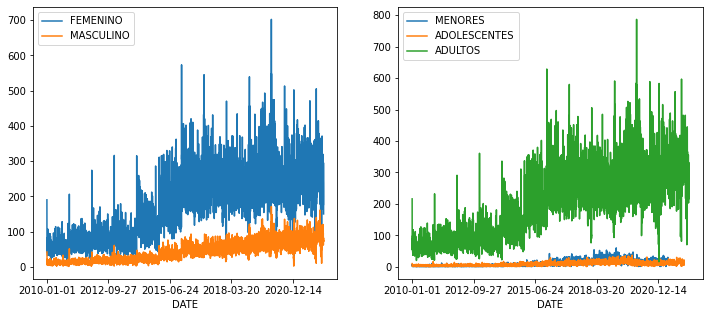

In [ ]:
def plot_violencia_genero_edad():
    dfviolencia = pd.read_csv("INPUTDATA/NEWCSV/ViolenciaIntrafamiliar-2010-2022.csv")
    #dfviolencia.head()
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax = ax.flatten()
    df2 = dfviolencia[["CANTIDAD", "DATE", "GENDER"]].groupby(["DATE", "GENDER"]).sum().sort_values(by="DATE", ascending=True).reset_index()
    df2.head()
    df2[df2["GENDER"] == "FEMENINO"].plot.line(x="DATE",ax=ax[0])
    df2[df2["GENDER"] == "MASCULINO"].plot.line(x="DATE",ax=ax[0])
    ax[0].legend(["FEMENINO", "MASCULINO"])

    df2 = dfviolencia[["CANTIDAD", "DATE", "GRUPO ETARIO"]].groupby(["DATE", "GRUPO ETARIO"]).sum().sort_values(by="DATE", ascending=True).reset_index()
    df2.head()
    df2[df2["GRUPO ETARIO"] == "MENORES"].plot.line(x="DATE",ax=ax[1])
    df2[df2["GRUPO ETARIO"] == "ADOLESCENTES"].plot.line(x="DATE",ax=ax[1])
    df2[df2["GRUPO ETARIO"] == "ADULTOS"].plot.line(x="DATE",ax=ax[1])
    #df2[df2["GENERO"] == "MASCULINO"].plot.line(x="FECHA",ax=ax[1])
    ax[1].legend(["MENORES", "ADOLESCENTES", "ADULTOS"])

plot_violencia_genero_edad()

# Geolocalización y Población

## Violencia intrafamiliar por departamento y año

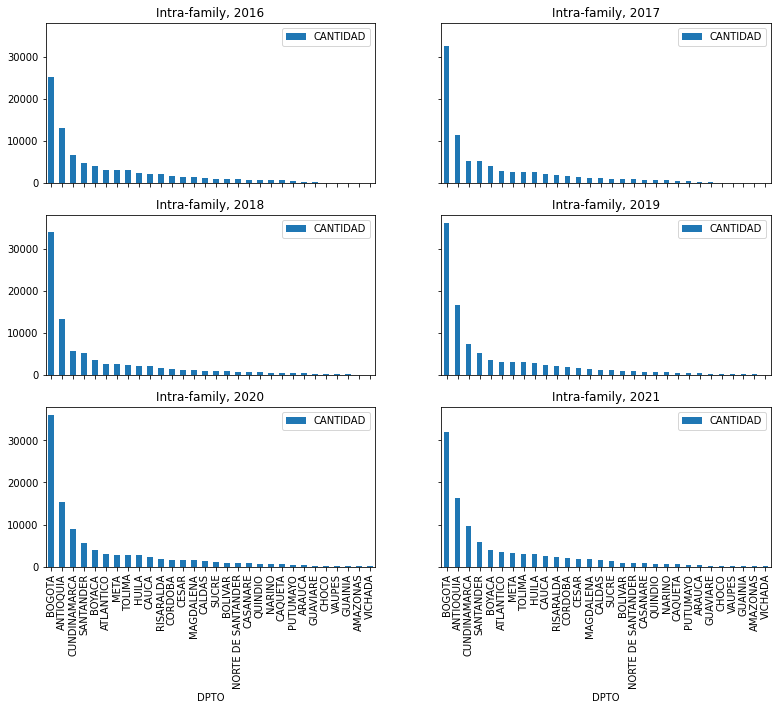

In [ ]:
plot_violencia_per_dpto_year_population(normalized=False)

## Violencia por año y por departamento, normalizado por población

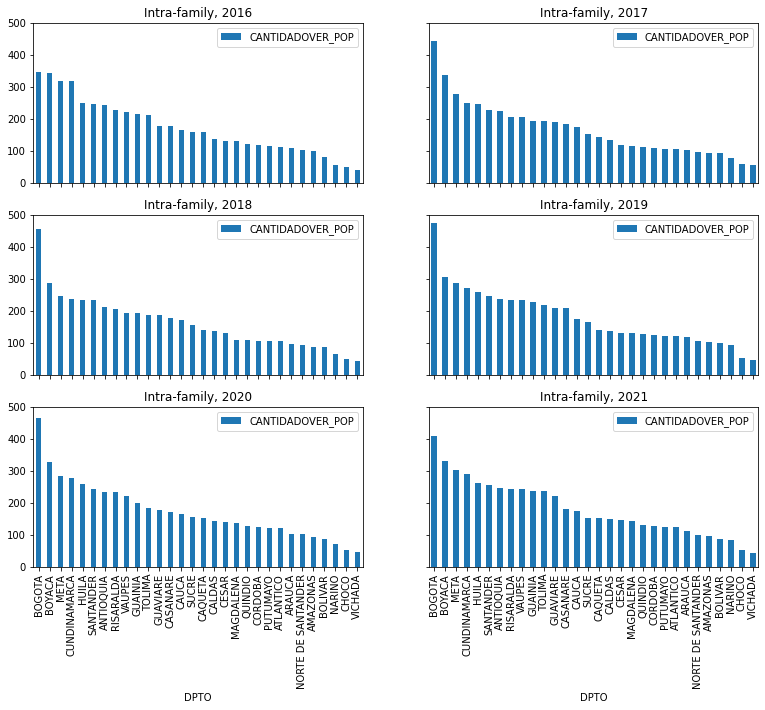

In [ ]:
plot_violencia_per_dpto_year_population(normalized=True)

## Suicidios por año y departamento

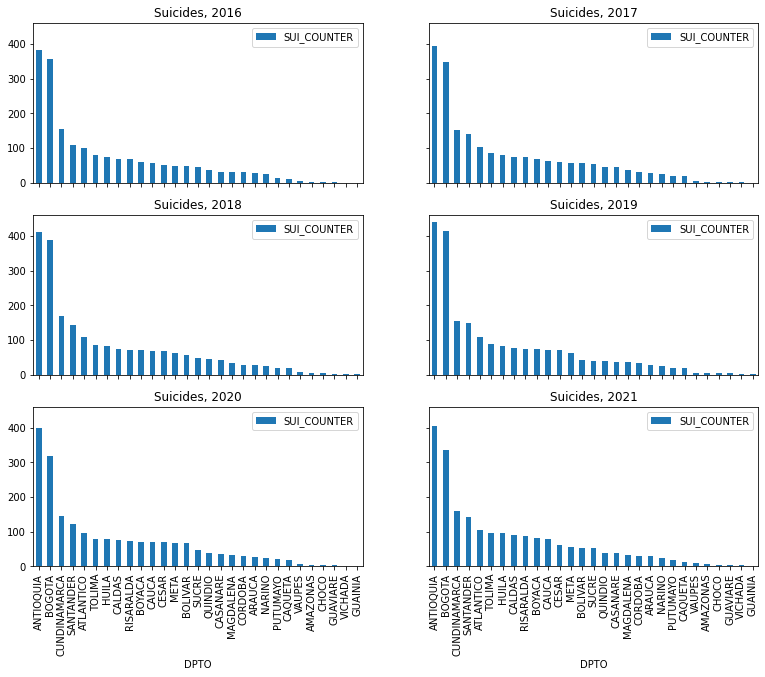

In [ ]:
plot_suicides_per_dpto_year_population(normalized=False)

## Suicidios por año y departamento, normalizados por población

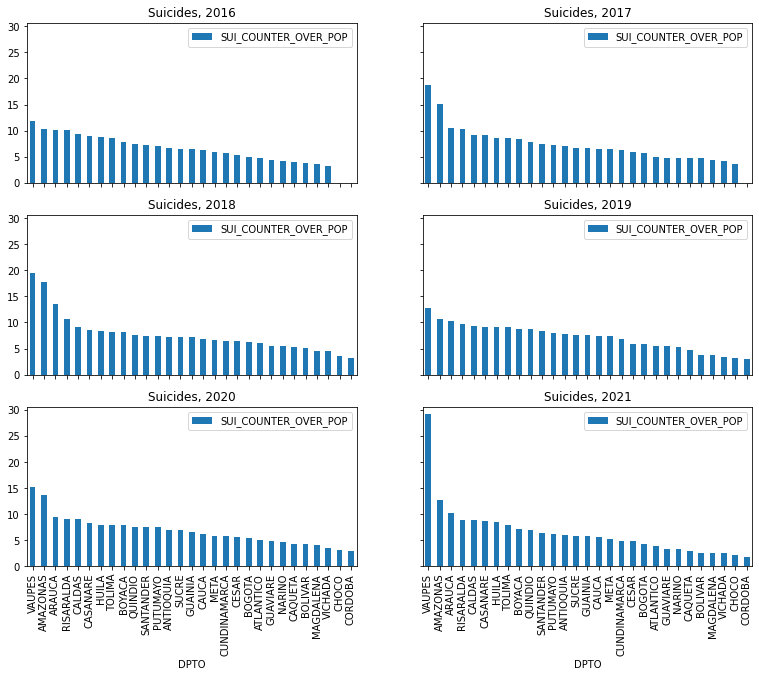

In [ ]:
plot_suicides_per_dpto_year_population(normalized=True)


## Map for municipios: Violencia intrafamiliar

Plan:
- [X] Read municipios and coordinate data, keep coordinates and cabecera municipal only -> geomunicipios
- [X] Merge violencia intrafamiliar and geomunicipios by municipio
- [X] Heat map for violencia
- [X] Merge suicides and geomunicipios by municipio
- [X] Heat map for suicide

In [ ]:
mapa = map_violencia_per_year_population(2020)
mapa

## Map por municipios: Suicidios

In [ ]:
mapa = map_suicides_per_year_population(2020)
mapa 



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=70a6331b-3e37-4c4d-8041-2d29d0ba96c1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>